In [3]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import os
import allensdk.core.json_utilities as ju


In [4]:
ea_params_hdf5 = h5py.File('/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_09_12_22_487664663_base5/genetic_alg/neuron_genetic_alg/params_allen_full_ea_2.hdf5','r')
compare_params_hdf5 = h5py.File('/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_09_17_22_487664663_ea_rank/genetic_alg/params/params_allen_full_sep11.hdf5','r')
template = pd.read_csv('/global/cscratch1/sd/zladd/axonstandardized/playground/runs/allen_full_09_12_22_487664663_base5/genetic_alg/params/params_allen_full.csv')

orig_params = template['Base value'].values
lbs = template['Lower bound'].values
ubs = template['Upper bound'].values
param_names = template['Param name'].values
bases = ubs / lbs
save=False

In [5]:
def load_npy_dir(path, extension):
    all_np = []
    for file in os.listdir(path):
        if extension in file:
            curr = np.load(os.path.join(path,file))
            all_np.append(curr)
    return np.array(all_np) # vstacK?

def save_pickle(path,data):
    with open(path,'wb') as f:
        pickle.dump(data,f)
    
def load_pickle(path):
    with open(path,'rb') as f:
        data = pickle.load(f)
    return data

def numpy_log(arr, base):
    if len(arr.shape) == 1:
        res = np.array([math.log(elem,base) for elem in arr])
    else:
        raise NotImplementedError
    return res

def numpy_pow(arr, base):
    if len(arr.shape) == 1:
        res = np.array([math.pow(base,elem) for elem in arr])
    else:
        raise NotImplementedError
    return res

def un_log_pop(population, linear_inds=[]):
    res = np.zeros_like(population)
    for gen in range(population.shape[0]):
        for param_ind in range(population.shape[-1]):
            if param_ind in linear_inds:
                continue
            res[gen,:,param_ind] = numpy_pow(population[gen,:,param_ind], bases[param_ind])
    return res

In [6]:
base_path = os.path.join('neuron_genetic_alg','extra_logs_mut1.5_eta40_cxpb1.5')

# load all pops
log_populations = load_npy_dir(base_path,'pop')
# undo log transform
populations =  un_log_pop(log_populations, linear_inds=[])


# load all hofs
log_hofs = load_npy_dir(base_path,'hof')
# undo log transform
hofs =  un_log_pop(log_hofs, linear_inds=[])

# load all scores
fitnesses = load_npy_dir(base_path,'score')


ValueError: x and y must have same first dimension, but have shapes (99,) and (1000,)

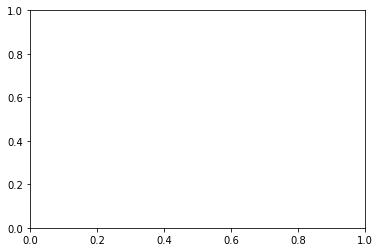

In [12]:
fitnesses.shape

plt.plot(np.arange(len(fitnesses)), np.min(fitnesses,axis=1))
plt.xlabel("generations")
plt.xlabel("objective value")

## Check that undo log transform adheres to bounds

In [5]:
verbose = False
for i in range(16):
    # verbose
    if verbose:
        print(f"param {param_names[i]} | min {lbs[i]}" + \
              f"  | pop_min: {np.min(populations[:,:,i])}" + \
              f"  | max: {ubs[i]} " + \
              f"  | pop_max: {np.max(populations[:,:,i])} \n") 
    # check all EA sampled param sets
    assert (np.min(populations[:,:,i]) > lbs[i]).all() & (np.max(populations[:,:,i]) < ubs[i]).all()
    if verbose:
        print('compare sampled min v.s. lb: ', np.min( compare_params_hdf5['pin_1000_full'][:,i]), lbs[i])
        print('compare sampled max v.s. ub: ', np.max( compare_params_hdf5['pin_1000_full'][:,i]), ubs[i], '\n')
    # check all compare sampled param sets
    assert (np.min( compare_params_hdf5['pin_1000_full'][:,i]) > lbs[i]).all() & (np.max(compare_params_hdf5['pin_1000_full'][:,i]) < ubs[i]).all()
# check origs match
assert (orig_params == compare_params_hdf5['orig_full'][:]).all()
print("all tests passed!")

all tests passed!


In [6]:
def param_distance(orig_params, param_sets, bases, param_idx):
    assert len(param_sets.shape) == 2
    res = numpy_log( param_sets[:,param_idx] / orig_params[param_idx], bases[param_idx] )
    return res
        

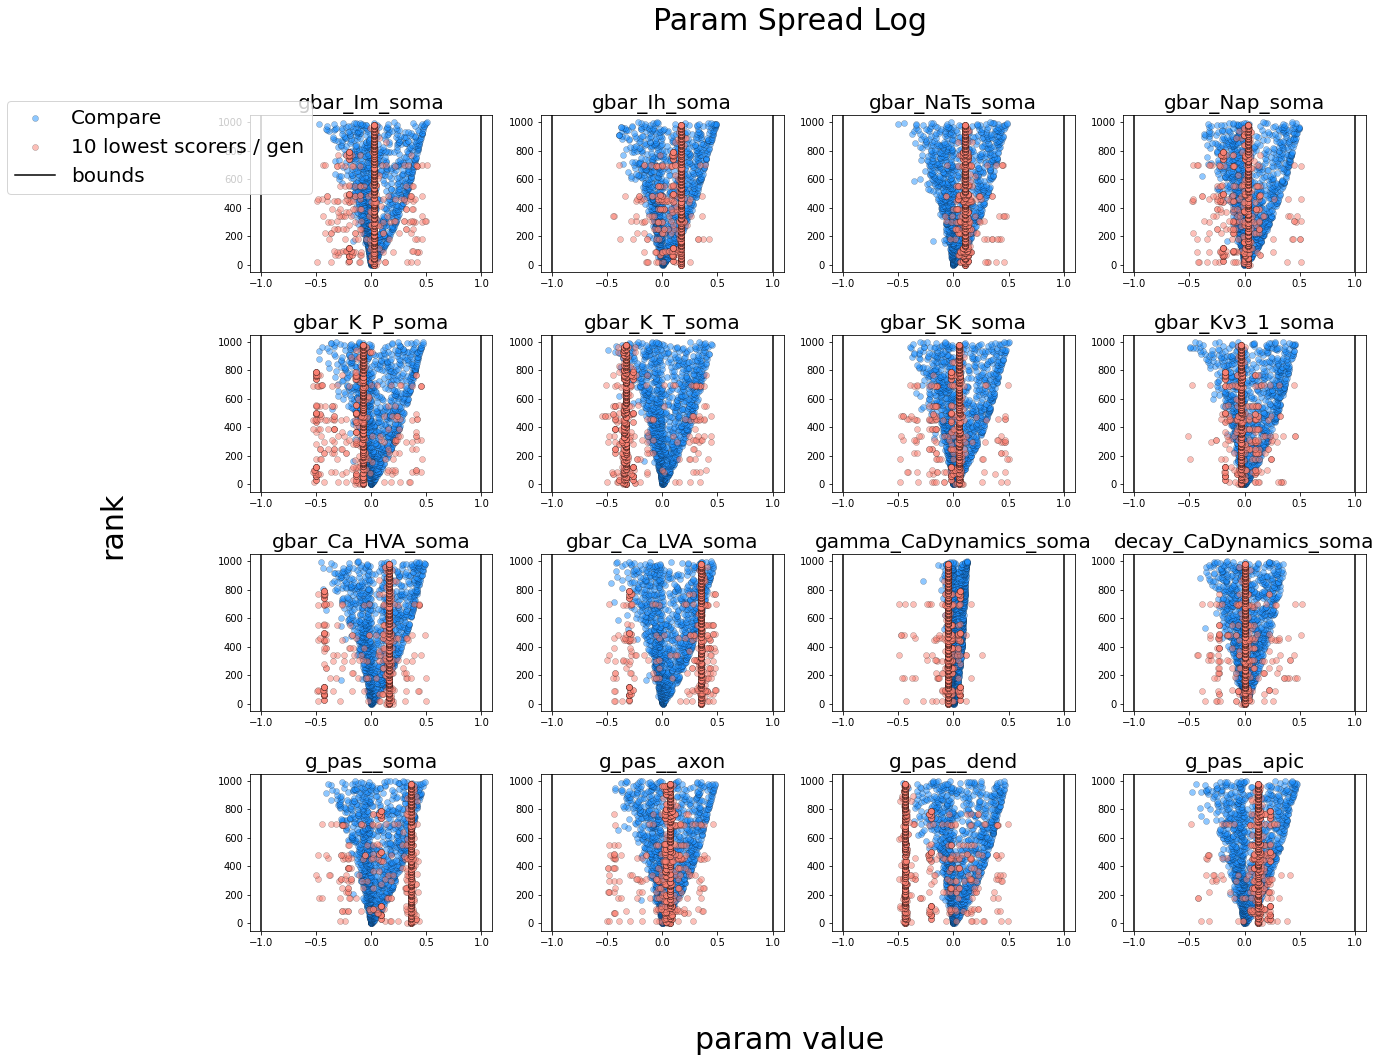

In [7]:
i = 0
fig, axs= plt.subplots(nrows=4, ncols=4, figsize=(20,15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.4)
ea_hof_label ='10 lowest scorers / gen'
compare_label ='Compare'
for param_idx, ax in enumerate(axs.flatten()):
    # print('plotting param : ', param_idx)
    # plot compare distance
    compare_dist = param_distance(orig_params,compare_params_hdf5['pin_1000_full'],bases,param_idx);
    ax.scatter(compare_dist, np.arange(len(compare_dist)), color='dodgerblue', alpha=.5, linewidth=.3, label=compare_label, edgecolor='black')
    compare_label = None
    
    # plot hof distance
    gen_idx_scale =len(compare_dist) // hofs.shape[0]  
    for gen_idx in range(hofs.shape[0]):
        score_hof_inds = np.argsort(fitnesses[gen_idx])[:10]
        score_hof = populations[gen_idx][score_hof_inds]
        # hof_dist = param_distance(orig_params,hofs[gen_idx],bases,param_idx)
        hof_dist = param_distance(orig_params,score_hof,bases,param_idx)

        ax.scatter(hof_dist, np.repeat(gen_idx*gen_idx_scale, len(hof_dist)), color='salmon', label=ea_hof_label, alpha=.5, linewidth=.3, edgecolor='black')
        ea_hof_label = None
        
    ax.axvline(-1, color='black', label='bounds')
    ax.axvline(1, color='black')
    if param_idx == 0:
        ax.legend(loc=[-1,.5], fontsize=20)
    ax.set_title(param_names[param_idx], fontsize=20)
fig.supxlabel('param value', fontsize=30)
fig.supylabel('rank', fontsize=30)
plt.suptitle('Param Spread Log', fontsize=30)
if save:
    plt.savefig('param_spread_log.png', facecolor='white', dpi=200, bbox_inches='tight')

In [9]:
allen_fit_params = ju.read('/global/cscratch1/sd/zladd/allen_optimize/biophys_optimize/test_storage/fit_parameters.json')
# allen_fit_params['genome']
# param_names, 
allen_correspondance = {}
for allen_entry in allen_fit_params['genome']:
    for name in param_names:
        name_match = allen_entry['name'] + '_' + allen_entry['section']
        if name.replace('__','_') == name_match:
            allen_correspondance[name] = allen_entry['value']

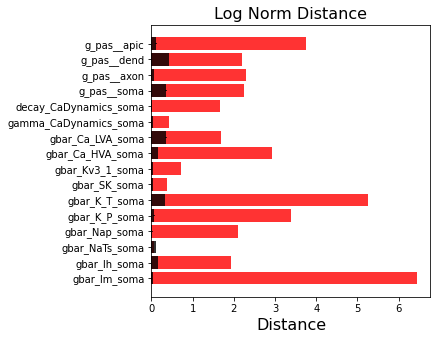

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
for param_idx, param_name in enumerate(param_names):
    hof_dist = np.abs(param_distance(orig_params,hofs[-1],bases,param_idx))
    allen_dist = np.abs(math.log(allen_correspondance[param_name],bases[param_idx])  )
    ax.barh(param_name, allen_dist, color='red', alpha=.8)
    ax.barh(param_name, np.mean(hof_dist),yerr=np.std(hof_dist), color='black',alpha=.8)

    # ax.barh(param_name, np.mean(hof_dist),yerr=np.std(hof_dist), color='black')

plt.title('Log Norm Distance', fontsize=16)
plt.xlabel("Distance", fontsize=16)
if save:
    plt.savefig('log_norm_distance.png', facecolor='white', bbox_inches='tight', dpi=200)

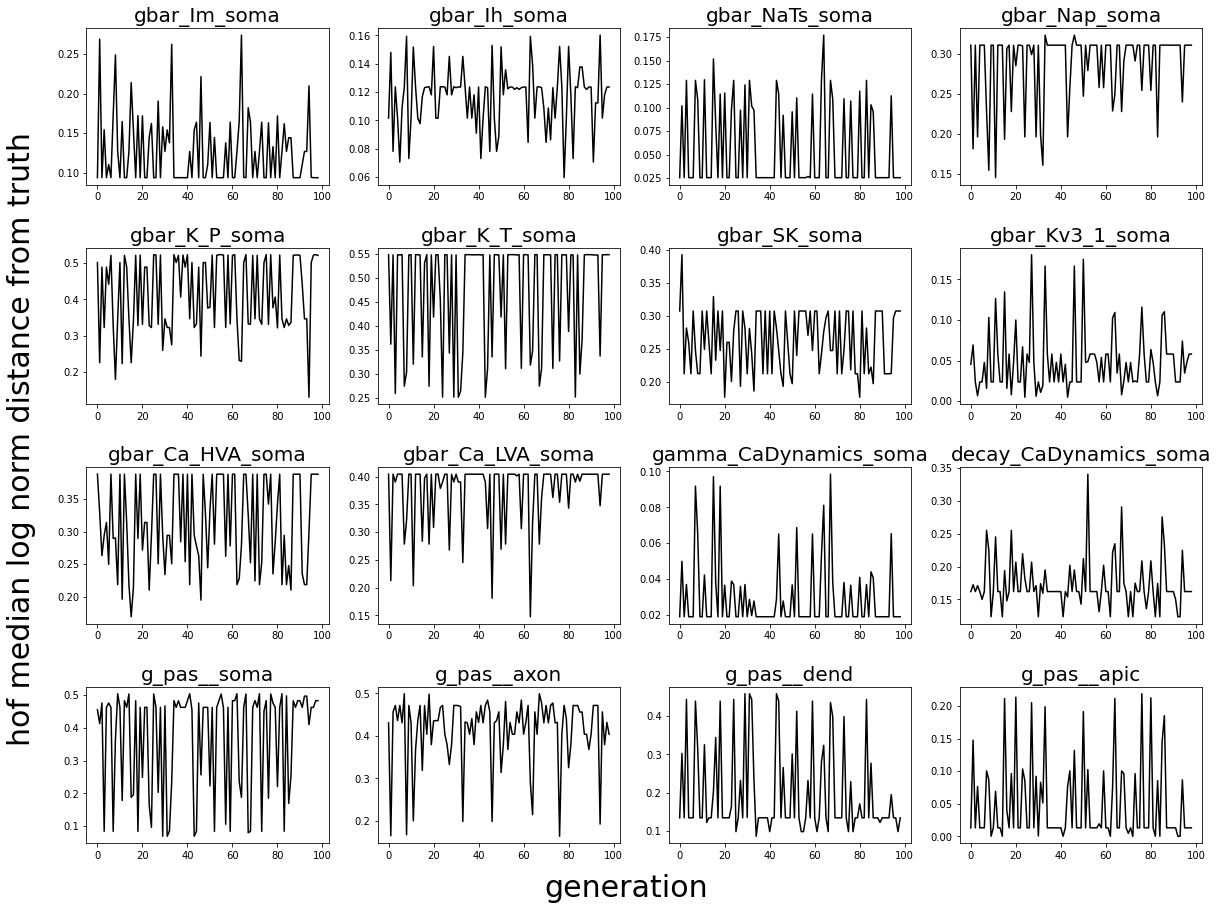

In [10]:
all_hof_distances = np.zeros(shape=(hofs.shape[0],hofs.shape[-1]))
fig, axs= plt.subplots(nrows=4, ncols=4, figsize=(20,15))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.4)
axs = axs.flatten()
for param_idx in range(hofs.shape[-1]):
    ax = axs[param_idx]
    for gen_idx in range(hofs.shape[0]):
        hof_dist = np.abs(param_distance(orig_params,hofs[gen_idx],bases,param_idx))
        all_hof_distances[gen_idx, param_idx]  = np.median(hof_dist)
    ax.plot(all_hof_distances[:,param_idx], color='black')
    # ax.plot(fitnesses, color='red')
    # if param_idx == 0:
        # ax.legend(loc=[-1,.5], fontsize=20)
    ax.set_title(param_names[param_idx], fontsize=20)
fig.supxlabel('generation', fontsize=30, y=.07)
fig.supylabel('hof median log norm distance from truth', fontsize=30, x=.07)
if save:
    plt.savefig('indv_param_distance_over_ea.png', facecolor='white', bbox_inches='tight', dpi=200)

In [ ]:
plt.plot(np.median(all_hof_distances,axis=1), label='median')
plt.plot(np.mean(all_hof_distances,axis=1), label='mean')
plt.legend(loc=[1.01,.8],fontsize=12)
plt.ylabel('distance', fontsize=14)
plt.xlabel('generation', fontsize=14)
plt.title('all param summary distance over EA progression', fontsize=14)
if save:
    plt.savefig("summary_distance.png", facecolor='white', bbox_inches='tight', dpi=200)

In [ ]:
plt.title("Param Variation Base", fontsize=20)
plt.ylabel("$\\frac{UB}{LB}$", fontsize=20)
plt.bar(param_names, bases)
plt.xticks(rotation=90)
plt.ylim(0,50)
if save:
    plt.savefig("param_var.png", bbox_inches = 'tight', facecolor='white', dpi=200)

In [56]:
np.max(curr_ea_params), np.min(curr_ea_params), ubs[i], lbs[i]

(0.9995070779412311,
 0.000407886005846958,
 0.0061843646176034,
 0.0002571083686413)

In [48]:
template

,Param name,Base value,Lower bound,Upper bound,Unit,Unit type,Const,Base variation estimation,Description,index in vector,Unnamed: 10,Peeling Step
0,gbar_Im_soma,1.238389e-03,2.571084e-04,6.184365e-03,NaN,Uniform,Open,2,NaN,1,0,passive
1,gbar_Ih_soma,6.338766e-04,1.336756e-04,3.041777e-03,NaN,Uniform,Open,3,NaN,2,0,passive
2,gbar_NaTs_soma,5.004534e-01,1.004096e-01,2.450538e+00,NaN,Uniform,Open,2,NaN,3,0,passive
3,gbar_Nap_soma,1.758571e-05,4.228247e-06,8.495584e-05,NaN,Uniform,Open,3,NaN,4,0,passive
4,gbar_K_P_soma,6.796869e-04,1.381251e-04,2.855086e-03,NaN,Uniform,Open,3,NaN,5,0,passive
5,gbar_K_T_soma,1.559857e-05,3.252088e-06,5.656405e-05,NaN,Uniform,Open,3,NaN,6,0,passive
6,gbar_SK_soma,5.304617e-04,1.190903e-04,2.508668e-03,NaN,Uniform,Open,3,NaN,7,0,passive
7,gbar_Kv3_1_soma,1.432246e-01,2.962186e-02,6.047375e-01,NaN,Uniform,Open,3,NaN,8,0,passive
8,gbar_Ca_HVA_soma,1.483592e-04,3.140013e-05,7.411796e-04,NaN,Uniform,Open,3,NaN,9,0,passive
9,gbar_Ca_LVA_soma,9.600187e-03,1.930895e-03,4.428976e-02,NaN,Uniform,Open,3,NaN,10,0,passive
